In [ ]:
!pip install dill
!pip3 install -q pybind11
!pip uninstall -q --yes gdown
!pip install -q gdown -U --no-cache-dir
!pip3 install -q --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/Edyarich/dlsystems-final-project
%cd dlsystems-final-project
!git checkout testing
!make

fatal: destination path 'dlsystems-final-project' already exists and is not an empty directory.
/content/dlsystems-final-project
Already on 'testing'
Your branch is up to date with 'origin/testing'.
-- Found pybind11: /usr/local/lib/python3.8/dist-packages/pybind11/include (found version "2.10.3")
-- Found cuda, building cuda backend
Sat Jan  7 20:47:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                

In [ ]:
import sys
sys.path.append('./python')

In [ ]:
# Download the datasets you will be using for this project
import os
import gdown
import importlib
from data.utils import rename_and_filter_images
import urllib.request


%cd ./data
DIRNAME = './landscapes/'

if not os.path.exists(DIRNAME):
    !gdown 14g49ILtIYKLt7WXaRPYyVfJGLHxcnQ7s
    !unzip -q landscapes -d landscapes
    !rm landscapes.zip

    rename_and_filter_images(DIRNAME)

%cd ../

/content/dlsystems-final-project/data
/content/dlsystems-final-project


In [ ]:
import needle as ndl
import needle.nn as nn
from apps.diffusion import Unet, Diffusion
from needle import array_api, Tensor, NDArray
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

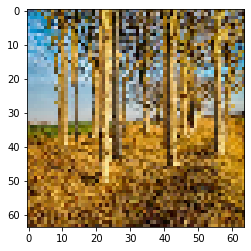

In [ ]:
from pathlib import Path
from needle.autograd import Tensor


def plot_landscape(img):
    img = np.transpose(img, (1, 2, 0))
    img = (img + 1) / 2
    plt.imshow(img);


DATA_DIR = Path('./data/landscapes/')
IMAGE_FILES = sorted(str(x) for x in list(DATA_DIR.rglob('*.jpg')))

transforms = [
    ndl.data.RandomFlipHorizontal(),
    ndl.data.Lambda(lambda img: np.transpose(img, (2, 0, 1))),
]

dataset = ndl.data.LandscapesDataset(
    IMAGE_FILES, extra_transforms=transforms, img_size=64
)
plot_landscape(dataset[12])

In [ ]:
device = ndl.cuda()
model = Unet(device=device)
optimizer = ndl.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
timesteps = 300
module = Diffusion(model, timesteps, loss_type="l2", device=device)

In [ ]:
epochs = 200
batch_size = 4
dataloader = ndl.data.DataLoader(dataset, batch_size, device=device)

In [ ]:
CHECKPOINT_STEP = 10

for epoch in range(1):
    for step, batch in enumerate(tqdm(dataloader)):
        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        
        optimizer.reset_grad()
        t = Tensor(np.random.randint(0, timesteps, (batch.shape[0],)),
                   device=device,
                   requires_grad=False)

        loss = module.p_losses(batch, t)

        if step % 50 == 0:
            print("Loss:", loss.cached_data[0])

        loss.backward()
        optimizer.step()

    if (epoch + 1) % CHECKPOINT_STEP == 0:
        ndl.save(model.state_dict(), 'diffusion.dill')

  0%|          | 0/1078 [00:00<?, ?it/s]

Loss: [1.9386483]


  5%|▍         | 50/1078 [00:34<13:06,  1.31it/s]

Loss: [0.82270837]


  9%|▉         | 100/1078 [01:08<10:38,  1.53it/s]

Loss: [0.6318268]


 14%|█▍        | 150/1078 [01:46<12:05,  1.28it/s]

Loss: [0.58990926]


 19%|█▊        | 200/1078 [02:20<10:50,  1.35it/s]

Loss: [0.4955912]


 23%|██▎       | 250/1078 [02:53<08:57,  1.54it/s]

Loss: [0.45304096]


 28%|██▊       | 300/1078 [03:30<09:23,  1.38it/s]

Loss: [0.425801]


 32%|███▏      | 350/1078 [04:08<08:13,  1.48it/s]

Loss: [0.38554803]


 37%|███▋      | 400/1078 [04:42<09:08,  1.24it/s]

Loss: [0.37611178]


 41%|████      | 439/1078 [05:09<07:31,  1.42it/s]


RuntimeError: ignored

In [ ]:
from google.colab import files
files.download('diffusion.dill') 

## Inference